# Single neuron modelling tutorial

In this tutorial we will see how to use experimental data from the Allen Institute for Brain Science Cell Types database and open-source software developed at the Blue Brain Project to constrain parameters of a multicompartmental neuron model with active dendrites.  

___
### Overview:

* We will use electrophysiological traces and a morphology of a [Layer 5 cortical interneuron from the visual cortex](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/475049291?mode-toggle.x=50&mode-toggle.y=55).


* Electrophysiological features will be extracted from the traces, thanks to the ** Electrophys Feature Extraction Library ** [eFEL](https://github.com/BlueBrain/eFEL).


* We will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [** NEURON simulator **](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters.
____

Most examples in this demo can be run from a web browser, thanks to Binder (http://mybinder.org/, supported by The Freeman Lab @ HHMI Janelia Research Campus).

To access the Binder instance set up for this demo, visit: ... 
You can run this tutorial on your computer, provided that your have NEURON/Python installed installed. The other libraries can be easily install using pip (see next section)
___

In [3]:
# Uncomment these lines if you want to install the required software on your computer.
# !pip install --user bluepyopt
# !pip install --user allensdk
# !pip install --user neurom

We first import some useful Python modules, the Allen SDK and API and the other libraries.

In [4]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
%matplotlib notebook
import matplotlib.pyplot as plt
import collections

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import numpy
import json

#  Experimental data
In this section we will process the electrophysiological data of a [Layer 5 cortical interneuron from the visual cortex](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/475049291?mode-toggle.x=50&mode-toggle.y=55) and load the morphology .swc file.

In [5]:
# Load the .nwb file containing the voltage traces
from allensdk.core.nwb_data_set import NwbDataSet
nwb_data = NwbDataSet('475049288.nwb')

For this example we have chosen to use two negative current steps and one positive and we assign a name to them; each step is associated with a sweep number. The data are stored in a Python dictionary.

In [6]:
# Store data in a dictionary step_name:sweep_num
steps_dict = collections.OrderedDict(sorted({'StepNeg1':23,'StepNeg2':26,'StepPos3':34}.items(), key = lambda x:x[0]))

def get_data(dataset,sweeps_dict):
    # Correct for the liquid junction potential
    junction_potential = -14
    data = collections.OrderedDict()
    for step, sweep in sweeps_dict.items():
        sweep_data = {}
        # Get sweep from NWB dataset
        sweep = dataset.get_sweep(sweep)

        # Get stimulus from the sweep
        # stimulus = sweep['stimulus']

        # Sampling rate is in Hz
        sampling_rate = sweep['sampling_rate']
        
        # Start/stop indices that exclude the experimental test pulse (if applicable)
        index_range = sweep['index_range']
        
        # Response is a numpy array in mV
        sweep_data['V'] = sweep['response'][index_range[0]:index_range[1]]*1000+junction_potential    
        
        # Define some time points in milliseconds (i.e., convert to absolute time)
        sweep_data['T'] = numpy.arange(0,(len(sweep_data['V'])/sampling_rate),1./sampling_rate)*1000
        data[step] = sweep_data
    return data

data_dict = get_data(nwb_data, steps_dict)

Load the morphology file and display with the library [**NeuroM**](https://github.com/BlueBrain/NeuroM) developed at BBP.

<IPython.core.display.Javascript object>


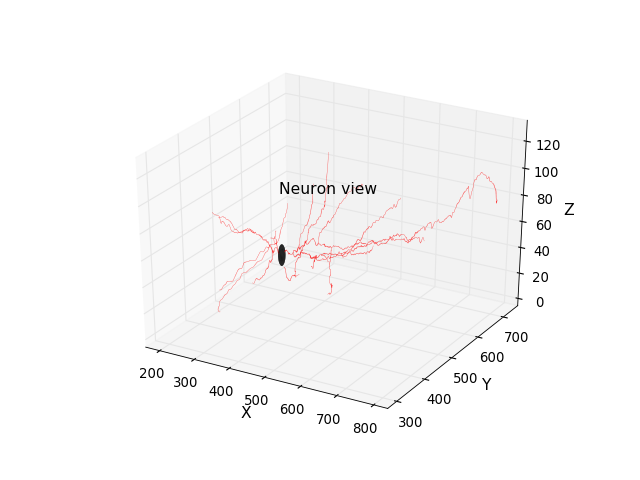

(<matplotlib.figure.Figure at 0x7fef7649d210>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fef76917e50>)

In [8]:
# Import NeuroM and display the morphology
from neurom import viewer, fst

morphology_file = 'Sst-IRES-Cre_Ai14_IVSCC_-183332.05.02.01_486041253_m.swc'
nrn = fst.load_neuron(morphology_file)
viewer.draw(nrn, mode='3d')

# Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The meatrics we use are the eFeatures, that measure parameters describing for instance the shape of the action potential or the firing properties of a neuron.

In this particular example, we extract distinct features from the responses to the negative and positive voltage steps.
The eFeatures extracted from the data and later from the model will be used to evaluate the results of the simulations. The features values, along with the standard deviations are stores in .json file.

In [9]:
# Extract features
import efel
def get_features(data):
    
    traces_pas = []
    traces_act = []
    for step_name, step_traces in data.items():
        trace = {}
        trace['T'] = data[step_name]['T']
        trace['V'] = data[step_name]['V']
        trace['stim_start'] = [270]
        trace['stim_end'] = [1270]
        trace['name'] = step_name
    
        if 'Pos' in step_name:
            traces_act.append(trace)       
        else:
            traces_pas.append(trace)
            
    features_values = efel.getMeanFeatureValues(traces_pas, ['time_constant', 'voltage_base',
                                                                    'voltage_deflection_begin', 'steady_state_hyper'])
    features_values_act = efel.getMeanFeatureValues(traces_act, ['mean_frequency', 'adaptation_index2', 'ISI_CV', 
                                                                'doublet_ISI', 'time_to_first_spike', 
                                                                'AHP_slow_time', 'AP_width', 'AP_height', 'Spikecount']) 
    features_values.extend(features_values_act)
    return features_values

efel_features = get_features(data_dict)

# Write features mean values and std in a json file
features_dict = collections.OrderedDict()
for step_name, features in zip(steps_dict.iterkeys(), efel_features):
    features_dict[step_name] = {"soma":{}}
    for name, value in features.items():
        features_dict[step_name]["soma"][name] = [value, abs(value*0.05)]    
    
with open('./config/features.json', 'w') as fp:
    json.dump(features_dict, fp, indent = 4)

# Model definition
In this section we will define the neuron model template and the parameters that we will optimize later on. The fixed parameters are taken from the "Biophysical - All active" model from the ABI models database. To download the original model uncomment the following lines.

In [10]:
# Download the cell model

# bp = BiophysicalApi()
# neuronal_model_id = 501349536
# bp.cache_data(neuronal_model_id, working_directory='neuronal_model')

In the following steps we will use some BluePyOpt functionalities to set-up the model template and optimize the free parameters. First of all, we use the "ephys" module to load the morphology. The axon is replaces by a model of the axonal initial segment (AIS).

In [11]:
morphology = ephys.morphologies.NrnFileMorphology(morphology_file, do_replace_axon=True)

The ion channel parameters and distribution in the different compartments (soma, basal dendrite, AIS) are stored in a json file (in "config/parameters.json")

In [12]:
# Parameters
param_configs = json.load(open('config/parameters.json'))
print [param_config['param_name'] for param_config in param_configs]

[u'g_pas', u'e_pas', u'g_pas', u'e_pas', u'g_pas', u'e_pas', u'cm', u'Ra', u'cm', u'Ra', u'cm', u'Ra', u'v_init', u'celsius', u'ena', u'ek', u'gbar_NaV', u'gbar_K_T', u'gbar_Kd', u'gbar_Kv2like', u'gbar_Kv3_1', u'gbar_SK', u'gbar_Ca_HVA', u'gbar_Ca_LVA', u'gamma_CaDynamics', u'decay_CaDynamics', u'gbar_NaV', u'gbar_SK', u'gbar_Kv3_1', u'gbar_Ca_HVA', u'gbar_Ca_LVA', u'gamma_CaDynamics', u'decay_CaDynamics', u'gbar_Ih', u'gbar_NaV', u'gbar_Kv3_1', u'gbar_Im_v2', u'gbar_Ih']


The file "cell_model.py" contains some helper functions for automatic creation of the model template. In this case we are loading the parameters we defined in the .json file. Note that some parameters have fixed values (they are "frozen" parameters), while others are defined as a range ("free" parameters).

In [38]:
# Insert parameters in cell model
import cell_model
parameters = cell_model.define_parameters()
print '\n'.join('%s' % param for param in parameters)

g_pas.somatic: ['somatic'] g_pas = 7.60303e-05
e_pas.somatic: ['somatic'] e_pas = -63.3146
g_pas.axonal: ['axonal'] g_pas = 0.00200656
e_pas.axonal: ['axonal'] e_pas = -71.1766
g_pas.basal: ['basal'] g_pas = 1.10433e-07
e_pas.basal: ['basal'] e_pas = -62.7085
cm.somatic: ['somatic'] cm = [0.4, 10]
Ra.somatic: ['somatic'] Ra = 72.0757
cm.axonal: ['axonal'] cm = [0.4, 10]
Ra.axonal: ['axonal'] Ra = 100.799
cm.basal: ['basal'] cm = [0.4, 10]
Ra.basal: ['basal'] Ra = 50.8833
v_init: v_init = -81
celsius: celsius = 34
ena.all: ['all'] ena = 53.0
ek.all: ['all'] ek = -107
gbar_NaV.axonal: ['axonal'] gbar_NaV = 0.0156789
gbar_K_T.axonal: ['axonal'] gbar_K_T = [1e-07, 0.01]
gbar_Kd.axonal: ['axonal'] gbar_Kd = 0.00833495
gbar_Kv2like.axonal: ['axonal'] gbar_Kv2like = 0.0010615
gbar_Kv3_1.axonal: ['axonal'] gbar_Kv3_1 = 0.0100065
gbar_SK.axonal: ['axonal'] gbar_SK = 0.00661877
gbar_Ca_HVA.axonal: ['axonal'] gbar_Ca_HVA = 3.83558e-05
gbar_Ca_LVA.axonal: ['axonal'] gbar_Ca_LVA = 0.00775489
gamma_

The parameters we defined above describe the maximal conductances of the ion channels and the kinetics parameters of the intracellular calcium dynamics. With the following function call, the .mod files that define the ion channel models are inserted in the model.

In [14]:
# Define mechanisms
!nrnivmodl modfiles
mechanisms = cell_model.define_mechanisms()
print '\n'.join('%s' % mech for mech in mechanisms)

Ih.basal: Ih at ['basal']
NaV.basal: NaV at ['basal']
Kv3_1.basal: Kv3_1 at ['basal']
Im_v2.basal: Im_v2 at ['basal']
pas.basal: pas at ['basal']
NaV.axonal: NaV at ['axonal']
K_T.axonal: K_T at ['axonal']
Kd.axonal: Kd at ['axonal']
Kv2like.axonal: Kv2like at ['axonal']
Kv3_1.axonal: Kv3_1 at ['axonal']
SK.axonal: SK at ['axonal']
Ca_HVA.axonal: Ca_HVA at ['axonal']
Ca_LVA.axonal: Ca_LVA at ['axonal']
CaDynamics.axonal: CaDynamics at ['axonal']
pas.axonal: pas at ['axonal']
NaV.somatic: NaV at ['somatic']
SK.somatic: SK at ['somatic']
Kv3_1.somatic: Kv3_1 at ['somatic']
Ca_HVA.somatic: Ca_HVA at ['somatic']
Ca_LVA.somatic: Ca_LVA at ['somatic']
CaDynamics.somatic: CaDynamics at ['somatic']
Ih.somatic: Ih at ['somatic']
pas.somatic: pas at ['somatic']


We are ready to create the cell model, with a simple call the class "CellModel" of the "ephys" module.

In [39]:
# Create the cell model
abi_cell = ephys.models.CellModel('abi_cell', morph=morphology, mechs=mechanisms, params=parameters)
print abi_cell

abi_cell:
  morphology:
    Sst-IRES-Cre_Ai14_IVSCC_-183332.05.02.01_486041253_m.swc
  mechanisms:
    Ih.basal: Ih at ['basal']
    NaV.basal: NaV at ['basal']
    Kv3_1.basal: Kv3_1 at ['basal']
    Im_v2.basal: Im_v2 at ['basal']
    pas.basal: pas at ['basal']
    NaV.axonal: NaV at ['axonal']
    K_T.axonal: K_T at ['axonal']
    Kd.axonal: Kd at ['axonal']
    Kv2like.axonal: Kv2like at ['axonal']
    Kv3_1.axonal: Kv3_1 at ['axonal']
    SK.axonal: SK at ['axonal']
    Ca_HVA.axonal: Ca_HVA at ['axonal']
    Ca_LVA.axonal: Ca_LVA at ['axonal']
    CaDynamics.axonal: CaDynamics at ['axonal']
    pas.axonal: pas at ['axonal']
    NaV.somatic: NaV at ['somatic']
    SK.somatic: SK at ['somatic']
    Kv3_1.somatic: Kv3_1 at ['somatic']
    Ca_HVA.somatic: Ca_HVA at ['somatic']
    Ca_LVA.somatic: Ca_LVA at ['somatic']
    CaDynamics.somatic: CaDynamics at ['somatic']
    Ih.somatic: Ih at ['somatic']
    pas.somatic: pas at ['somatic']
  params:
    g_pas.somatic: ['somatic'] g_pas 

In the next step we will fit the maximal conductance of some of the ion channels in order to reproduce the eFeatures we have extracted from the data. In the following line we can see what are the "free" parameters.

In [16]:
# Parameters to optimize
param_names = [param.name for param in abi_cell.params.values() if not param.frozen]
print param_names

[u'cm.somatic', u'cm.axonal', u'cm.basal', u'gbar_K_T.axonal', u'gbar_NaV.somatic', u'gbar_Kv3_1.somatic']


# Setting-up a simulation
To evaluate the behavior of the model, we need to set-up a simulation. To reproduce the experimental sweeps we have chosen, we define three current protocols that match the experimental counterparts. The protocols information is also stored in a .json file and can be automaically loaded.

In [40]:
import cell_evaluator
proto_configs = json.load(open('config/protocols.json'))
fitness_protocols = cell_evaluator.define_protocols()

print proto_configs

{u'StepPos3': {u'stimuli': [{u'delay': 270, u'amp': 0.11, u'duration': 1000, u'totduration': 1540}]}, u'StepNeg1': {u'stimuli': [{u'delay': 270, u'amp': -0.11, u'duration': 1000, u'totduration': 1540}]}, u'StepNeg2': {u'stimuli': [{u'delay': 270, u'amp': -0.05, u'duration': 1000, u'totduration': 1540}]}}


Thanks to another helper class of the BluePyOpt library it is easy to define a simulation. The additional file "cell_evaluator.py" can be used to set up the simulation and define a scoring system that will be used by the genetic algorithm.

In [41]:
# Set-up a simulation and a fitness calculator
sim = ephys.simulators.NrnSimulator()
fitness_calculator = cell_evaluator.define_fitness_calculator(fitness_protocols)

evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=abi_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

The result of the simulations can be visualized in the different ways. For example, the following function plots the experimental and model responses one on top of the other.

In [28]:
def plot_data(sweep_data, sweeps_list, model_responses = []):
    fig, axes = plt.subplots(len(sweeps_list), figsize=(10,10))
    
    for index, sweep, (resp_name, model) in zip(range(len(sweeps_list)),sweeps_list, sorted(model_responses.items())):
        sweep = sweep_data.get_sweep(sweep)

        # Get stimulus from the sweep
        stimulus = sweep['stimulus']

        # Sampling rate is in Hz
        sampling_rate = sweep['sampling_rate']
        
        # Start/stop indices that exclude the experimental test pulse (if applicable)
        index_range = sweep['index_range']
        
        # Response is a numpy array in Volts
        response = sweep['response'][index_range[0]:index_range[1]]*1000    
        
        # Define some time points in seconds (i.e., convert to absolute time)
        time_pts = numpy.arange(0,(len(response)/sampling_rate),1./sampling_rate)
        
        #func = interpolate.interp1d(time_pts, response, kind = 'quadratic')
        axes[index].plot(time_pts, response-14, label = 'Data')
        #axes[index].plot(time_pts+delay,stim)
        axes[index].plot(model['time']/1000, model['voltage'], label = 'Model')
       
        axes[index].set_xlim([0.0, 1.54])
        axes[index].set_xlabel("Time (s)")
        axes[index].set_ylabel("Voltage (mV)")
        #axes[index].set_title(resp_name)
        axes[index].legend(loc='best')
    fig.show()

With the following function call we run a simulation with parameters from the original ABI model. We can also print the scores of the original model. This score measures the difference of each eFeature of the model from the experimental one and penalize the eFeatures that display the wider experimental variability (in our case all the features have the same STD). A "perfect" model would have a score close to 0.

<IPython.core.display.Javascript object>


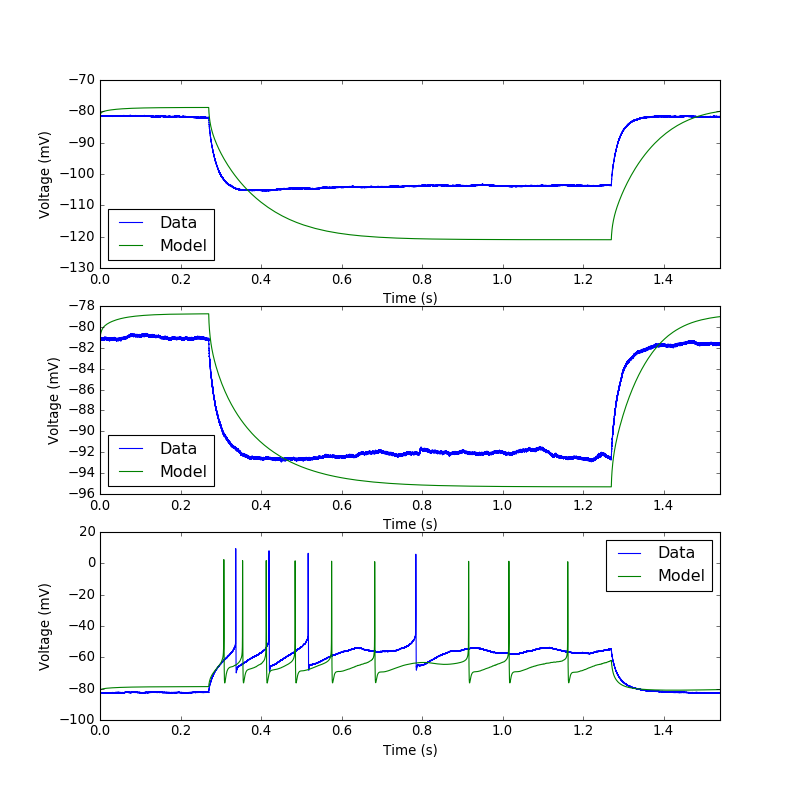

Sum of all feature values: 256.441041111
Average of the feature values: 15.0847671242


In [29]:
orig_params = json.load(open('orig_parameters.json'))
abi_cell.unfreeze(abi_cell.params)
orig_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values = orig_params)
plot_data(nwb_data,[23, 26, 34], orig_responses)

scores =  fitness_calculator.calculate_scores(orig_responses)
sum = numpy.sum([value for value in scores.values()])
avg = numpy.mean([value for value in scores.values()])

print "Sum of all feature values: " + str(sum)
print "Average of the feature values: " + str(avg)

# Parameters optimization 
We are now ready to run an optimisation. This is a procedure that requires supercomputing resources and can take from some hours to days. for a proof of concept, we will run two optimization with a small population of individual for a small number of generations.

In [48]:
import time
# Run for 2 generations
import pickle

# Re-initialize the model parameters
param_configs = json.load(open('config/parameters.json'))
parameters = cell_model.define_parameters()
abi_cell = ephys.models.CellModel('abi_cell', morph=morphology, mechs=mechanisms, params=parameters)

evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=abi_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

num_gen = 2
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=10) 

start = time.time()
results = opt.run(max_ngen=num_gen, cp_filename='checkpoints/checkpoint_'+str(num_gen)+'.pkl')
end = time.time()
print "Run time in seconds: " + str(end-start)

cp = pickle.load(open('checkpoints/checkpoint_'+str(num_gen)+'.pkl'))
results = (cp['population'],
        cp['halloffame'],
        cp['logbook'],
        cp['history'])


pop, hall_of_fame_2, log, hist = results

Run time in seconds: 122.463513851


After two generations, the model result is not very satisfying.

<IPython.core.display.Javascript object>


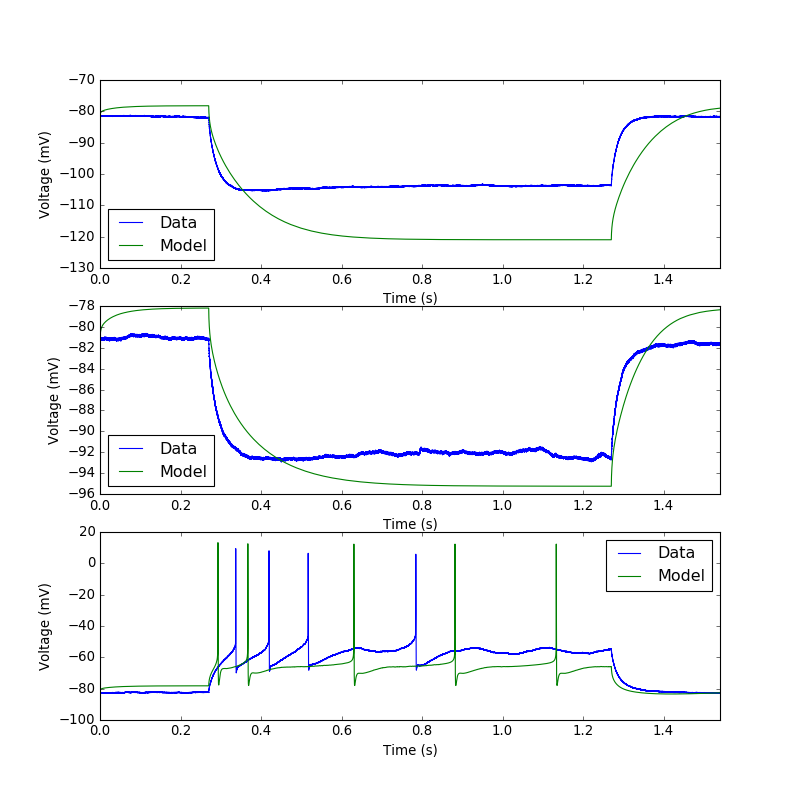

gen	nevals	avg    	std    	min    	max    
1  	10    	1243.78	340.167	747.786	2123.44
2  	10    	1214.8 	393.17 	227.725	2123.44


In [51]:
# Plot responses of the best individual
best_params_2 = evaluator.param_dict(hall_of_fame_2[0])
best_responses_2 = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params_2)

plot_data(nwb_data,[23, 26, 34],best_responses_2)
print log

We run a slightly longer optimization.

In [44]:
# Run for 8 generations
import time

num_gen = 8
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=10) 

start = time.time()
results = opt.run(max_ngen=num_gen, cp_filename='checkpoints/checkpoint_'+str(num_gen)+'.pkl')
#final_pop, halloffame, log, hist = opt.run(max_ngen=2, cp_filename='checkpoints/checkpoint.pkl')
end = time.time()
print "Run time in seconds: " + str(end-start)

cp = pickle.load(open('checkpoints/checkpoint_'+str(num_gen)+'.pkl'))
results = (cp['population'],
        cp['halloffame'],
        cp['logbook'],
        cp['history'])

pop, hall_of_fame, log, hist = results

Run time in seconds: 619.940378904


We can also plot the evolution of the feature values from generation to generation. Although the result is not yet satisfying, we can observe a progressive convergence of the model features values toward the experimental ones.

<IPython.core.display.Javascript object>


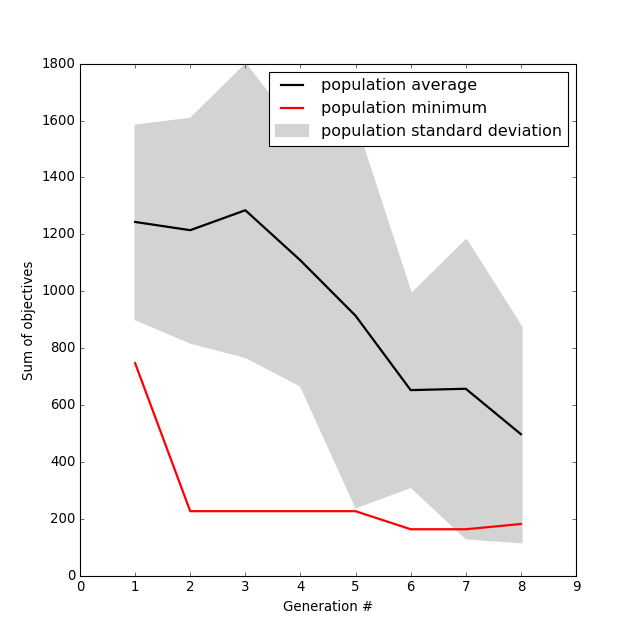

In [45]:
gen_numbers = log.select('gen')
min_fitness = numpy.array(log.select('min'))
max_fitness = log.select('max')
mean_fitness = numpy.array(log.select('avg'))
std_fitness = numpy.array(log.select('std'))

fig, ax = plt.subplots(1, figsize=(8, 8), facecolor='white')
#fig_trip, ax_trip = plt.subplots(1, figsize=(10, 5), facecolor='white')

#plot_count = len(responses)
std = std_fitness
mean = mean_fitness
minimum = min_fitness
stdminus = mean - std                                                           
stdplus = mean + std

ax.plot(                                                                      
    gen_numbers,                                                                
    mean,                                                                       
    color='black',                                                              
    linewidth=2,                                                                
    label='population average')                                                 

ax.fill_between(                                                              
    gen_numbers,                                                                
    stdminus,                                                                   
    stdplus,                                                                    
    color='lightgray',                                                          
    linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(                                                                      
    gen_numbers,                                                                
    minimum,                                                                    
    color='red',                                                                
    linewidth=2,                                                                
    label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('Sum of objectives')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend()          

Plotting the voltager responses shows that the result can still be improved.

<IPython.core.display.Javascript object>


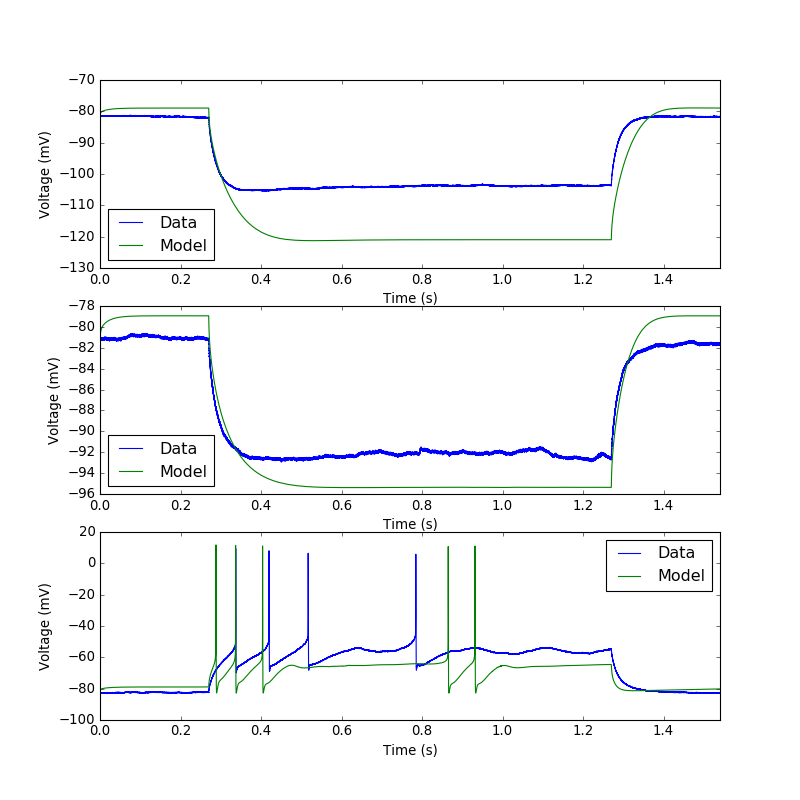

gen	nevals	avg    	std    	min    	max    
1  	10    	1243.78	340.167	747.786	2123.44
2  	10    	1214.8 	393.17 	227.725	2123.44
3  	10    	1284.91	513.74 	227.725	2123.44
4  	10    	1108.68	438.424	227.725	2123.44
5  	10    	914.288	670.218	227.725	2123.44
6  	10    	653.015	337.712	164.225	1198.94
7  	10    	657.707	523.673	164.225	2159.35
8  	10    	498.263	377.818	182.722	1438.92


In [46]:
# Plot responses of the best individual
best_params_10 = evaluator.param_dict(hall_of_fame[0])
best_responses_10 = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params_10)
#print halloffame[0]
plot_data(nwb_data,[23, 26, 34],best_responses_10)
print log